In [52]:
import layoutparser as lp
import cv2

image_og = cv2.imread("3.png")
image = image_og[..., ::-1]

In [53]:
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [54]:
layout = model.detect(image)

In [55]:
print(type(layout))
print(layout[0])

<class 'layoutparser.elements.layout.Layout'>
TextBlock(block=Rectangle(x_1=63.567508697509766, y_1=1973.7291259765625, x_2=293.47467041015625, y_2=2121.255126953125), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9999401569366455)


In [56]:
text_blocks = lp.Layout([b for b in layout if b.type=='TextRegion']) #and b.score>0.91
figure_blocks = lp.Layout([b for b in layout if b.type=='ImageRegion'])

text_blocks = lp.Layout([b for b in text_blocks if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [57]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [58]:
def merge_text_blocks(text_blocks):
    shift_thresh = 20 
    area_thresh = 10

    text_blocks_merged = text_blocks[:]

    for i in range(len(text_blocks)):
        for j in range(i+1, len(text_blocks)):
            
            a, b = text_blocks[i], text_blocks[j]

            dx = min(a.block.x_2, b.block.x_2) - max(a.block.x_1, b.block.x_1)
            dy = min(a.block.y_2, b.block.y_2) - max(a.block.y_1, b.block.y_1)
            
            if not((dx>=0) and (dy>=0)): #Rectangles don't overlap
                continue

            #Finding Percentage of Intersection Area
            instersection_area = dx * dy
            union_area = a.width * a.height + b.width * b.height - instersection_area
            percent_overlap = (instersection_area / union_area) * 100
            
            #Finding Horizontal Shifts
            bottom_shift = abs(a.block.x_2 - b.block.x_2) 
            top_shift = abs(a.block.x_1 - b.block.x_1)

            if bottom_shift < shift_thresh and top_shift < shift_thresh and percent_overlap > area_thresh:
                # print(i, j, percent_overlap, top_shift, bottom_shift)
                try:
                    text_blocks_merged.remove(text_blocks[i])
                    text_blocks_merged.remove(text_blocks[j])
                except ValueError:
                    pass
                
                text_blocks_merged.append(text_blocks[i].union(text_blocks[j]))

    for i in range(len(text_blocks_merged)):
        text_blocks_merged[i].id = i

    text_blocks_merged = lp.Layout(text_blocks_merged)
    return text_blocks_merged      

text_blocks_merged = merge_text_blocks(text_blocks) 

for _ in range(3):
    text_blocks_merged = merge_text_blocks(text_blocks_merged)     

In [59]:
for block in figure_blocks:
    x1, y1, x2, y2 = block.block.x_1, block.block.y_1, block.block.x_2, block.block.y_2
    image_og = cv2.rectangle(image_og, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), -1)

image = image_og[..., ::-1]

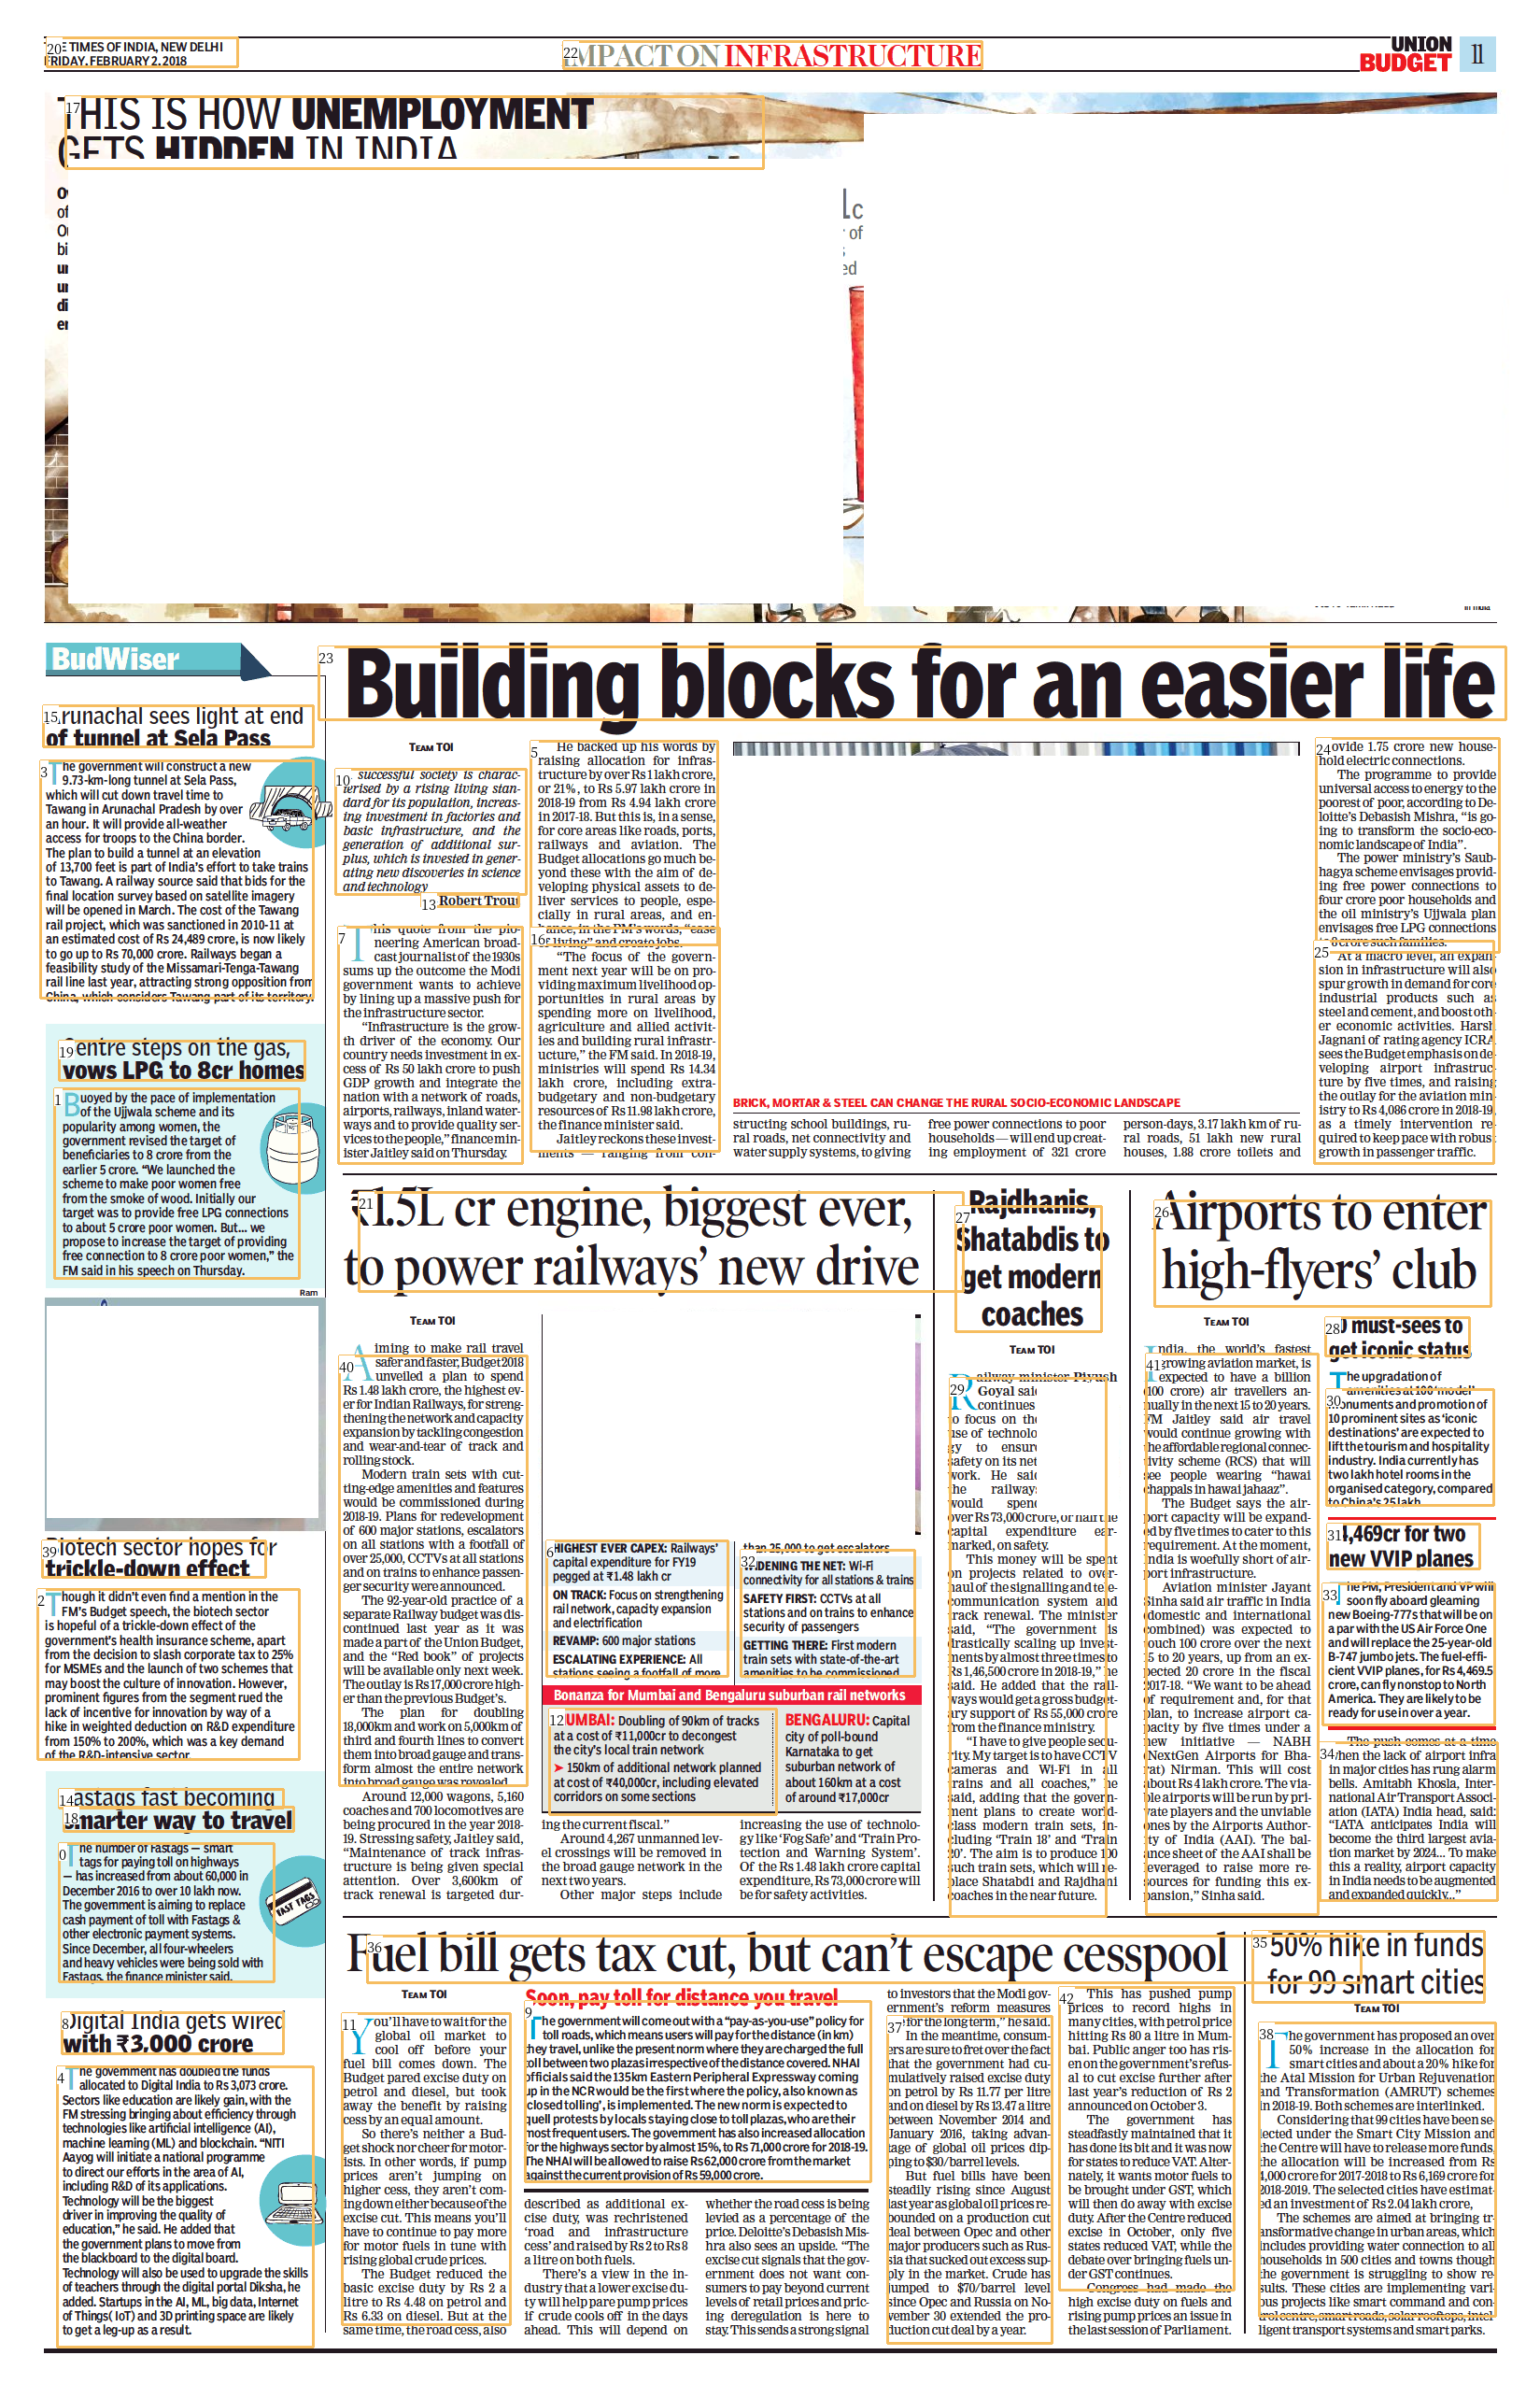

In [60]:
lp.draw_box(image, text_blocks_merged,
            box_width=3,
            show_element_id=True)

In [61]:
i=63
x1, y1, x2, y2 = text_blocks[i].block.x_1, text_blocks[i].block.y_1, text_blocks[i].block.x_2, text_blocks[i].block.y_2
cropped_img = image[int(y1):int(y2), int(x1):int(x2)]
cv2.imwrite("cropped.png", cropped_img)

IndexError: list index out of range